Step 1. Import Libraries

In [1]:
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable 

import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

Step 2. Initial setting

In [3]:
channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))
latent_dim = 100 # suggested default. dimensionality of the latent space



Step 3. Define Generator

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize: # Default
                layers.append(nn.BatchNorm1d(output_features))
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # inplace=True : modify the input directly. It can slightly decrease the memory usage.
            return layers # return list of layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Asterisk('*') in front of block means unpacking list of layers - leave only values(layers) in list
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))), # np.prod(1, 28, 28) == 1*28*28
            nn.Tanh() # result : from -1 to 1
        )

    def forward(self, z): # z == latent vector(random input vector)
        img = self.model(z) # (64, 100) --(model)--> (64, 784)
        img = img.view(img.size(0), *img_shape) # img.size(0) == N(Batch Size), (N, C, H, W) == default --> (64, 1, 28, 28)
        return img

Step 4. Define Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512), # (28*28, 512)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # result : from 0 to 1
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1) #flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat) # Discriminate -> Real? or Fake? (64, 784) -> (64, 1)
        return validity

Step 5. Define Loss Function

In [6]:
adversarial_loss = torch.nn.BCELoss()

Step 6. Initialize generator and Discriminator

In [7]:
generator = Generator()
discriminator = Discriminator()

generator
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Step 7. Configure Data Loader

In [8]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.Compose(
                           [#transforms.Resize(img_size), # Resize is only for PIL Image. Not for numpy array
                            transforms.ToTensor(), # ToTensor() : np.array (H, W, C) -> tensor (C, H, W)
                            transforms.Normalize([0.5],[0.5])]),
    download = True 
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transforms.Compose(
                           [#transforms.Resize(img_size), # Resize is only for PIL Image. Not for numpy array
                            transforms.ToTensor(), # ToTensor() : np.array (H, W, C) -> tensor (C, H, W)
                            transforms.Normalize([0.5],[0.5])])
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.2MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 305kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.10MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.30MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



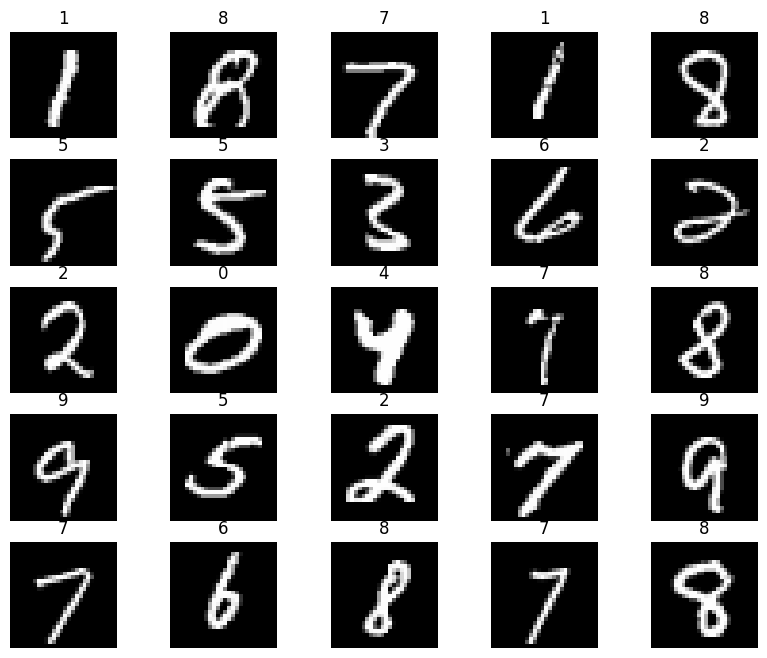

In [9]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [10]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True),
}
loaders


{'train': <torch.utils.data.dataloader.DataLoader at 0x1623d6530>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1623d5630>}

In [11]:
temp_img=train_data.__getitem__(0)
print("shape of images:{}".format(temp_img[0].size()))
print("maximum and minimum:{} , {}".format(temp_img[0].max(), temp_img[0].min()))

shape of images:torch.Size([1, 28, 28])
maximum and minimum:1.0 , -1.0


Step 8. Define optimizers

In [12]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002 

In [13]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))


In [14]:
Tensor = torch.FloatTensor


In [15]:
# Visualize result
import matplotlib.pyplot as plt


Step 9. Training


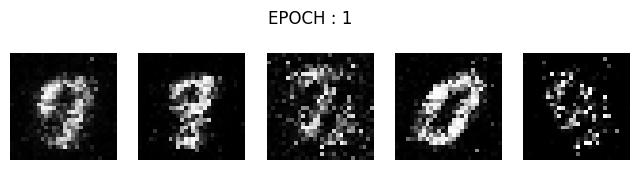

[Epoch: 1/100] [D loss: 0.827714] [G loss: 0.647938]


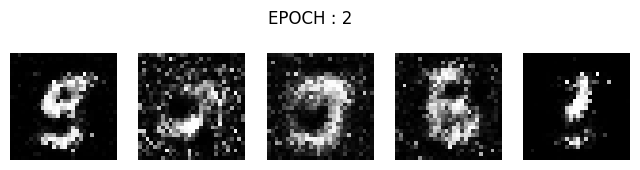

[Epoch: 2/100] [D loss: 0.920227] [G loss: 0.639202]


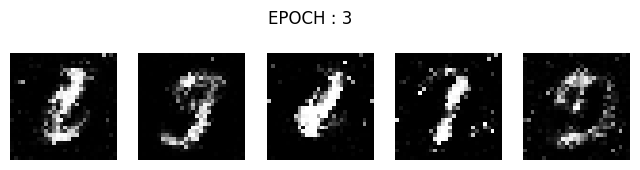

[Epoch: 3/100] [D loss: 0.961402] [G loss: 0.631495]


KeyboardInterrupt: 

In [16]:
n_epochs = 100 # suggested default = 200

for epoch in range(n_epochs):
    loss_for_epoch_generator=[]
    loss_for_epoch_discriminator=[]
    
    for i, (imgs, _) in enumerate(loaders['train']): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                      
        
        # Adversarial ground truths (For more detail, refer *Read_More below)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to. 
                                                                                # requires_grad=False is default in tensor type. *Read_More
        
        # Configure input
        real_imgs = imgs.type(Tensor) # As mentioned, it is no longer necessary to wrap the tensor in a Variable.
        # real_imgs = Variable(imgs.type(Tensor)) # requires_grad=False, Default! It's same.
        # Generate a batch of images
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        gen_imgs = generator(z)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])
    
    
    
# ------------
# Train Discriminator
# ------------
        optimizer_D.zero_grad()
        
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake) # We are learning the discriminator now. So have to use detach() 
                                                                             
        d_loss = (real_loss + fake_loss) / 2
        loss_for_epoch_discriminator.append(d_loss.item())
        
        d_loss.backward()# If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward(). 
        optimizer_D.step()
    
# ------------
# Train Generator
# ------------
        optimizer_G.zero_grad()
        
        # sample noise 'z' as generator input
        # Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        # z.shape == torch.Size([64, 100])
        
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        
        loss_for_epoch_generator.append(g_loss.item())
        
        g_loss.backward()
        optimizer_G.step()
         
    

# ------------
# Real Time Visualization (While Training)
# ------------
        
    sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
    # z.shape == torch.Size([64, 100])
    sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
    # gen_imgs.shape == torch.Size([64, 1, 28, 28])

    nrow=1
    ncols=5
    fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
    plt.suptitle('EPOCH : {}'.format(epoch+1))
    for ncol in range(ncols):
        axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
        axes[ncol].axis('off')
    plt.show()
    print(
        "[Epoch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, np.mean(np.array(loss_for_epoch_generator)), np.mean(np.array(loss_for_epoch_discriminator)))
    )

Step 10. Test the GAN skills

In [ ]:
#define fixed noise for comparison
np.random.seed(0)
fixed_noise = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))

#generate fake images
with torch.no_grad():
    fake = generator(fixed_noise).detach().cpu()


#take a batch of real images
real_batch = next(iter(loaders['test']))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0].cpu()[:64],padding=5)[0,:,:].cpu(),cmap='gray')

# Plot the fake images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(vutils.make_grid(fake[:64],padding=5)[0,:,:].cpu(),cmap='gray')
plt.show()
